<a href="https://colab.research.google.com/github/Dethkalleon/AILabs/blob/main/AI4_V3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ЛР4

# Лабораторная работа №4

ФИО: Солдаткин Андрей Алексеевич

Группа: БИВТ-22-СП-4

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1k2MYXEp_OVQrink_XRC1PwoM0ZuNMeNz4VTWY7cI3hE/edit?usp=sharing) необходимо узнать название своего датасета
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

# Подключение Гугл Диска


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Считывание данных и подключение библиотек

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

# Загрузка данных
data = pd.read_csv('/content/drive/MyDrive/MSAD/Salary_Data.csv')

# Замена значений в столбце 'Education Level' для корректности
data['Education Level'] = data['Education Level'].replace({
    "Bachelor's Degree": "Bachelor's",
    "Master's Degree": "Master's",
    "phD": "PhD"
})

# Проверка на пропуски
print("Пропущенные значения в данных:")
print(data.isnull().sum())

Пропущенные значения в данных:
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


#Проверка на тип задачи

In [3]:
# Проверка структуры данных и целевого признака
print(data.describe())
data['Salary'].unique()

# Если 'Salary' числовой -> задача регрессии.
# Если категориальный -> задача классификации.
if data['Salary'].dtype in ['int64', 'float64']:
    print("Это задача регрессии.")
else:
    print("Это задача классификации.")

               Age  Years of Experience         Salary
count  6702.000000          6701.000000    6699.000000
mean     33.620859             8.094687  115326.964771
std       7.614633             6.059003   52786.183911
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000
Это задача регрессии.


#Заполнение пропусков

16.12 А что если удалить все данные? Нужно проверить, может так лучше будет?

In [4]:
# Удаление строк с пропусками во всех переменных, включая целевую
data_clean = data.dropna()

# Проверка на наличие пропусков после удаления
print("Пропущенные значения после удаления:")
print(data_clean.isnull().sum())

# Вывод количества удаленных строк
removed_rows = len(data) - len(data_clean)
print(f"Удалено строк с пропусками: {removed_rows}")

Пропущенные значения после удаления:
Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64
Удалено строк с пропусками: 6


#Преобразование категориальных переменных

In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_clean['Gender'] = labelencoder.fit_transform(data_clean['Gender'])
data_clean['Education Level'] = labelencoder.fit_transform(data_clean['Education Level'])
data_clean['Job Title'] = labelencoder.fit_transform(data_clean['Job Title'])
data_clean.head(20)

<ipython-input-5-315e28d135ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Gender'] = labelencoder.fit_transform(data_clean['Gender'])
<ipython-input-5-315e28d135ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Education Level'] = labelencoder.fit_transform(data_clean['Education Level'])
<ipython-input-5-315e28d135ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,1,0,175,5.0,90000.0
1,28.0,0,2,18,3.0,65000.0
2,45.0,1,3,144,15.0,150000.0
3,36.0,0,0,115,7.0,60000.0
4,52.0,1,2,25,20.0,200000.0
5,29.0,1,0,93,2.0,55000.0
6,42.0,0,2,106,12.0,120000.0
7,31.0,1,0,118,4.0,80000.0
8,26.0,0,0,94,1.0,45000.0
9,38.0,1,3,165,10.0,110000.0


#Разделение на признаки и целевую. Train/Test

In [7]:
# Разделение на признаки (X) и целевую переменную (Y)
X = data_clean.drop(columns=['Salary'])
Y = data_clean['Salary']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Вывод размеров тренировочной и тестовой выборки
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Общее количество записей: {X.shape[0]}")


Размер тренировочной выборки: (5358, 5)
Размер тестовой выборки: (1340, 5)
Общее количество записей: 6698


#Проверочка

In [8]:
X_train.head(5)


,Age,Gender,Education Level,Job Title,Years of Experience
3426,39.0,1,2,135,10.0
1552,38.0,0,2,3,10.0
6021,35.0,0,3,113,12.0
4461,30.0,0,1,82,1.0
3286,23.0,0,0,175,1.0


In [9]:
X_test.head(5)

,Age,Gender,Education Level,Job Title,Years of Experience
1883,36.0,1,2,3,9.0
2630,27.0,0,2,43,4.0
498,25.0,0,2,18,1.0
5973,28.0,0,0,93,3.0
4108,29.0,1,0,174,5.0


In [10]:
print(X_train.dtypes)  # Типы данных в признаках
print(Y_train.dtypes)  # Тип данных в целевой переменной

Age                    float64
Gender                   int64
Education Level          int64
Job Title                int64
Years of Experience    float64
dtype: object
float64


In [11]:
print(Y_train.isnull().sum())  # Проверить количество NaN
print(Y_test.isnull().sum())  # Проверить количество NaN

0
0


In [12]:
print(X_train.isnull().sum())  # Проверить количество NaN
print(X_test.isnull().sum())  # Проверить количество NaN

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
dtype: int64
Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
dtype: int64


#Преобразование численных переменных

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Применяем MinMaxScaler к нужным столбцам
data_clean[['Age', 'Years of Experience']] = scaler.fit_transform(data_clean[['Age', 'Years of Experience']])
data_clean.head(5)

<ipython-input-13-24c893d9294c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[['Age', 'Years of Experience']] = scaler.fit_transform(data_clean[['Age', 'Years of Experience']])


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,0.268293,1,0,175,0.147059,90000.0
1,0.170732,0,2,18,0.088235,65000.0
2,0.585366,1,3,144,0.441176,150000.0
3,0.365854,0,0,115,0.205882,60000.0
4,0.756098,1,2,25,0.588235,200000.0


#Предобработка

In [14]:
target_column = 'Salary'

# Разделяем признаки (X) и целевую переменную (y)
X = data_clean.drop(columns=[target_column])
y = data_clean[target_column]

# Разделение на train и test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Данные успешно разделены на train и test.")

# --- B и C. Предобработка числовых и категориальных данных ---
# Выделим числовые и категориальные признаки
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создаем трансформеры для обработки данных
numeric_transformer = StandardScaler()  # Нормализация числовых признаков
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # Кодирование категориальных признаков

# Объединяем трансформеры в один ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Преобразуем данные
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("Данные успешно предобработаны!")


Данные успешно разделены на train и test.
Данные успешно предобработаны!


In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

# --- Создание класса Dataset ---
class CustomDataset(Dataset):
    def __init__(self, X, y, use_log_transform=False):
        self.X = torch.tensor(X, dtype=torch.float32)

        # Логарифмирование целевой переменной, если указано
        if use_log_transform:
            self.y = torch.tensor(torch.log(torch.tensor(y.values, dtype=torch.float32) + 1), dtype=torch.float32)
        else:
            self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Создаем объекты Dataset с логарифмированием ---
train_dataset = CustomDataset(X_train, y_train, use_log_transform)
test_dataset = CustomDataset(X_test, y_test, use_log_transform)

# --- Создаем DataLoader для батчевой загрузки данных ---
batch_size = 32  # Размер батча
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Данные успешно оформлены в Dataset и DataLoader с логарифмированием" if use_log_transform else "Данные успешно оформлены в Dataset и DataLoader!")


Данные успешно оформлены в Dataset и DataLoader с логарифмированием таргета!


<ipython-input-29-01c4b4b08228>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.log(torch.tensor(y.values, dtype=torch.float32) + 1), dtype=torch.float32)


In [35]:
import torch.nn as nn
import torch.optim as optim

# --- A. Однослойная нейросеть с оптимизатором SGD ---
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Один слой

    def forward(self, x):
        return self.fc(x)

# --- Функция для обучения модели ---
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()  # Режим обучения
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

        # Валидация на test_loader
        model.eval()  # Режим валидации
        with torch.no_grad():
            val_loss = sum(criterion(model(inputs).squeeze(), targets) for inputs, targets in test_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# --- Инициализация первой модели ---
input_size = X_train.shape[1]
model_1 = SimpleNet(input_size)
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01)
criterion = nn.MSELoss()  # Для задачи регрессии используем MSE

# Обучение модели
print("Обучение простой однослойной нейросети:")
train_model(model_1, optimizer_1, criterion, train_loader, test_loader)

# --- B. Нейросеть с одним скрытым слоем и оптимизатором Adam ---
class MediumNet(nn.Module):
    def __init__(self, input_size):
        super(MediumNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  # Скрытый слой на 64 нейрона
        self.fc2 = nn.Linear(16, 1)  # Выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Инициализация второй модели
model_2 = MediumNet(input_size)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

# Обучение модели
print("\nОбучение нейросети с одним скрытым слоем:")
train_model(model_2, optimizer_2, criterion, train_loader, test_loader)

# --- C. Нейросеть с тремя скрытыми слоями и оптимизатором Adam ---
class ComplexNet(nn.Module):
    def __init__(self, input_size):
        super(ComplexNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Инициализация третьей модели
model_3 = ComplexNet(input_size)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)

# Обучение модели
print("\nОбучение нейросети с тремя скрытыми слоями:")
train_model(model_3, optimizer_3, criterion, train_loader, test_loader)


Обучение простой однослойной нейросети:
Epoch [1/10], Train Loss: 1.8618, Val Loss: 11.9090
Epoch [2/10], Train Loss: 0.1691, Val Loss: 5.8468
Epoch [3/10], Train Loss: 0.0939, Val Loss: 5.7580
Epoch [4/10], Train Loss: 0.1053, Val Loss: 5.6962
Epoch [5/10], Train Loss: 0.1631, Val Loss: 5.6581
Epoch [6/10], Train Loss: 0.0924, Val Loss: 5.6213
Epoch [7/10], Train Loss: 0.1361, Val Loss: 5.6202
Epoch [8/10], Train Loss: 0.2739, Val Loss: 5.6099
Epoch [9/10], Train Loss: 0.1487, Val Loss: 5.5809
Epoch [10/10], Train Loss: 0.0941, Val Loss: 5.5950

Обучение нейросети с одним скрытым слоем:
Epoch [1/10], Train Loss: 95.6656, Val Loss: 4018.8618
Epoch [2/10], Train Loss: 39.2084, Val Loss: 1756.3419
Epoch [3/10], Train Loss: 14.3972, Val Loss: 638.5568
Epoch [4/10], Train Loss: 10.0553, Val Loss: 397.7400
Epoch [5/10], Train Loss: 3.6308, Val Loss: 280.2138
Epoch [6/10], Train Loss: 3.0652, Val Loss: 199.0783
Epoch [7/10], Train Loss: 2.5979, Val Loss: 144.9123
Epoch [8/10], Train Loss: 3.

Обучение SimpleNet для построения learning curve:
Epoch [1/10], Train Loss: 0.1318, Val Loss: 0.1329
Epoch [2/10], Train Loss: 0.1321, Val Loss: 0.1338
Epoch [3/10], Train Loss: 0.1315, Val Loss: 0.1337
Epoch [4/10], Train Loss: 0.1318, Val Loss: 0.1332
Epoch [5/10], Train Loss: 0.1316, Val Loss: 0.1328
Epoch [6/10], Train Loss: 0.1318, Val Loss: 0.1332
Epoch [7/10], Train Loss: 0.1318, Val Loss: 0.1334
Epoch [8/10], Train Loss: 0.1320, Val Loss: 0.1330
Epoch [9/10], Train Loss: 0.1322, Val Loss: 0.1327
Epoch [10/10], Train Loss: 0.1317, Val Loss: 0.1327

Обучение MediumNet для построения learning curve:
Epoch [1/10], Train Loss: 1.2602, Val Loss: 1.1809
Epoch [2/10], Train Loss: 0.9909, Val Loss: 0.9237
Epoch [3/10], Train Loss: 0.7921, Val Loss: 0.7388
Epoch [4/10], Train Loss: 0.6468, Val Loss: 0.6025
Epoch [5/10], Train Loss: 0.5380, Val Loss: 0.4970
Epoch [6/10], Train Loss: 0.4588, Val Loss: 0.4258
Epoch [7/10], Train Loss: 0.4008, Val Loss: 0.3729
Epoch [8/10], Train Loss: 0.359

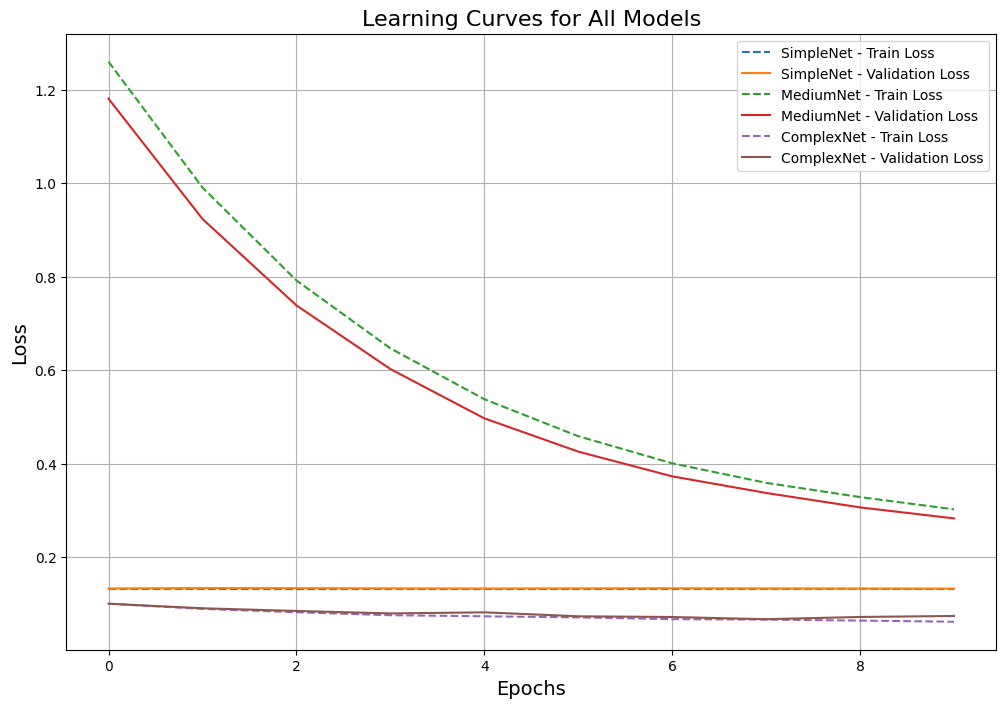

In [36]:
# --- Модифицированная функция для обучения с сохранением loss ---
def train_model_with_curve(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Режим обучения
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))  # Средний train loss

        # Валидация на test_loader
        model.eval()  # Режим валидации
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))  # Средний val loss

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

#Обучение моделей и сбор данных для графиков
learning_curves = {}

# Обучение модели SimpleNet
print("Обучение SimpleNet для построения learning curve:")
train_losses_1, val_losses_1 = train_model_with_curve(model_1, optimizer_1, criterion, train_loader, test_loader)
learning_curves['SimpleNet'] = (train_losses_1, val_losses_1)

# Обучение модели MediumNet
print("\nОбучение MediumNet для построения learning curve:")
train_losses_2, val_losses_2 = train_model_with_curve(model_2, optimizer_2, criterion, train_loader, test_loader)
learning_curves['MediumNet'] = (train_losses_2, val_losses_2)

# Обучение модели ComplexNet
print("\nОбучение ComplexNet для построения learning curve:")
train_losses_3, val_losses_3 = train_model_with_curve(model_3, optimizer_3, criterion, train_loader, test_loader)
learning_curves['ComplexNet'] = (train_losses_3, val_losses_3)

# --- Построение графиков ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# SimpleNet
plt.plot(learning_curves['SimpleNet'][0], label='SimpleNet - Train Loss', linestyle='--')
plt.plot(learning_curves['SimpleNet'][1], label='SimpleNet - Validation Loss')

# MediumNet
plt.plot(learning_curves['MediumNet'][0], label='MediumNet - Train Loss', linestyle='--')
plt.plot(learning_curves['MediumNet'][1], label='MediumNet - Validation Loss')

# ComplexNet
plt.plot(learning_curves['ComplexNet'][0], label='ComplexNet - Train Loss', linestyle='--')
plt.plot(learning_curves['ComplexNet'][1], label='ComplexNet - Validation Loss')

# Настройки графика
plt.title('Learning Curves for All Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [37]:
from sklearn.metrics import mean_absolute_error

# Функция для вычисления MAE
def evaluate_model(model, data_loader, criterion):
    model.eval()
    targets_all = []
    predictions_all = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs).squeeze()
            targets_all.extend(targets.numpy())
            predictions_all.extend(outputs.numpy())

    mae = mean_absolute_error(targets_all, predictions_all)
    return mae

print("Оценка моделей на Train и Test множествах:")

mae_train_1 = evaluate_model(model_1, train_loader, criterion)
mae_test_1 = evaluate_model(model_1, test_loader, criterion)
print(f"SimpleNet - MAE (Train): {mae_train_1:.4f}, MAE (Test): {mae_test_1:.4f}")

mae_train_2 = evaluate_model(model_2, train_loader, criterion)
mae_test_2 = evaluate_model(model_2, test_loader, criterion)
print(f"MediumNet - MAE (Train): {mae_train_2:.4f}, MAE (Test): {mae_test_2:.4f}")

mae_train_3 = evaluate_model(model_3, train_loader, criterion)
mae_test_3 = evaluate_model(model_3, test_loader, criterion)
print(f"ComplexNet - MAE (Train): {mae_train_3:.4f}, MAE (Test): {mae_test_3:.4f}")

Оценка моделей на Train и Test множествах:
SimpleNet - MAE (Train): 0.2618, MAE (Test): 0.2624
MediumNet - MAE (Train): 0.3631, MAE (Test): 0.3631
ComplexNet - MAE (Train): 0.1838, MAE (Test): 0.1908
